# ERA5-WRF Output Visualization
Plots domain topography, radar reflectivity + wind barbs, and an interactive animation over all forecast hours.

In [1]:
import glob, os
import netCDF4 as nc
from datetime import datetime

# ── USER CONFIGURATION ────────────────────────────────────────────────────────
TARGET_TIME = '20190125 18:00'   # desired valid time  YYYYMMDD HH:MM
ERA5_DIR    = './era5'           # root era5 output directory
DOMAIN      = 'd01'
SKIP_BARB   = 10    # plot every Nth wind barb in each direction
# ─────────────────────────────────────────────────────────────────────────────

target_dt = datetime.strptime(TARGET_TIME, '%Y%m%d %H:%M')

# Parse valid time from wrfout filename  (wrfout_d01_YYYY-MM-DD_HH:MM:SS)
def parse_wrfout_time(path):
    name = os.path.basename(path)
    ts   = '_'.join(name.split('_')[2:])   # e.g. '2019-01-25_18:00:00'
    return datetime.strptime(ts, '%Y-%m-%d_%H:%M:%S')

# Find all wrfout files across all run subdirs under ERA5_DIR
all_wrfout = sorted(glob.glob(os.path.join(ERA5_DIR, f'**/wrfout_{DOMAIN}_*'), recursive=True))
if not all_wrfout:
    raise FileNotFoundError(f'No wrfout files found under {ERA5_DIR}')

wrfout_times = [parse_wrfout_time(f) for f in all_wrfout]
deltas       = [abs((t - target_dt).total_seconds()) for t in wrfout_times]
best_idx     = deltas.index(min(deltas))

WRFOUT_FILE  = all_wrfout[best_idx]
VALID_TIME   = wrfout_times[best_idx]
RUN_DIR      = os.path.dirname(WRFOUT_FILE)

print(f'Target  : {target_dt}')
print(f'Selected: {VALID_TIME}  ({WRFOUT_FILE})')
print(f'Run dir : {RUN_DIR}')


Target  : 2019-01-25 18:00:00
Selected: 2019-01-25 18:00:00  (./era5/2019012512/wrfout_d01_2019-01-25_18:00:00)
Run dir : ./era5/2019012512


In [2]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from IPython.display import display
import netCDF4 as nc
import wrf
import pyart

# ChaseSpectral was added in newer pyart (>=2.x); fall back gracefully.
try:
    REFL_CMAP = pyart.graph.cm.ChaseSpectral
    print('Using pyart ChaseSpectral colormap')
except AttributeError:
    try:
        REFL_CMAP = plt.get_cmap('ChaseSpectral')
        print('Using ChaseSpectral colormap')
    except (ValueError, KeyError):
        REFL_CMAP = plt.get_cmap('NWSRef')
        print('ChaseSpectral not available, using NWSRef')


print('All imports OK')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

Using ChaseSpectral colormap
All imports OK


In [3]:
# ── Open all wrfout files for animation; also set selected file for single-time plot ──
# Single selected file (for Section 2 reflectivity plot)
ncfile  = nc.Dataset(WRFOUT_FILE)

# All files in the same run directory, sorted chronologically (for Section 3 animation)
all_files = sorted(glob.glob(os.path.join(RUN_DIR, f"wrfout_{DOMAIN}_*")))
ncfiles   = [nc.Dataset(f) for f in all_files]
print(f"Selected file : {WRFOUT_FILE}")
print(f"Total files for animation: {len(ncfiles)}")


Selected file : ./era5/2019012512/wrfout_d01_2019-01-25_18:00:00
Total files for animation: 13


In [4]:
# ── Cartopy projection from WRF metadata ──────────────────────────────────────
cart_proj = wrf.get_cartopy(wrfin=ncfiles[0])
lats = wrf.getvar(ncfiles[0], 'lat')
lons = wrf.getvar(ncfiles[0], 'lon')

lat_min, lat_max = float(lats.min()), float(lats.max())
lon_min, lon_max = float(lons.min()), float(lons.max())
print(f'Domain: lat [{lat_min:.2f}, {lat_max:.2f}]  lon [{lon_min:.2f}, {lon_max:.2f}]')

Domain: lat [-37.83, -27.42]  lon [-75.66, -55.34]


## 1. Domain Map — Topography

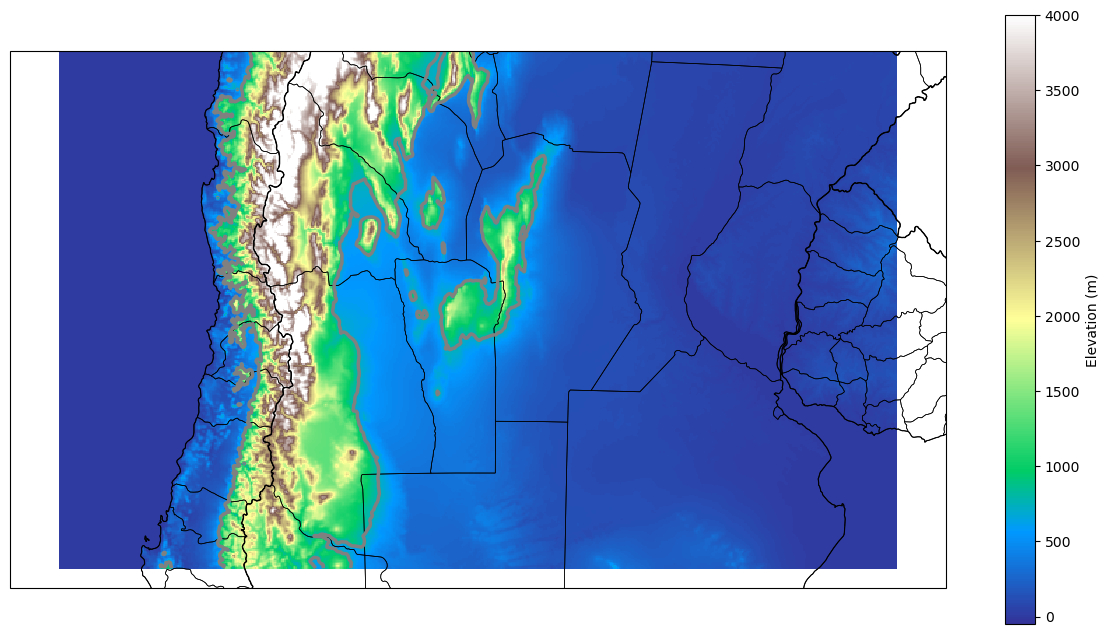

In [5]:
ter = wrf.getvar(ncfiles[0], 'ter', timeidx=0)

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': cart_proj})
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

topo_im = ax.pcolormesh(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(ter),
                         cmap='terrain', vmin=-50, vmax=4000,
                         transform=ccrs.PlateCarree())
plt.colorbar(topo_im, ax=ax, label='Elevation (m)', shrink=0.7)

# 750 m contour — thick gray
ax.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(ter),
            levels=[750], colors='gray', linewidths=2.5,
            transform=ccrs.PlateCarree())

ax.add_feature(cfeature.BORDERS, linewidth=1.0, edgecolor='black')
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

# ax.set_title('WRF Domain — Terrain Height (m)  |  gray contour = 750 m', fontsize=13)
plt.tight_layout()
plt.savefig(os.path.join(RUN_DIR, 'domain_topo.png'), dpi=150, bbox_inches='tight')
plt.show()

## 2. Single-time Reflectivity + Wind Barbs

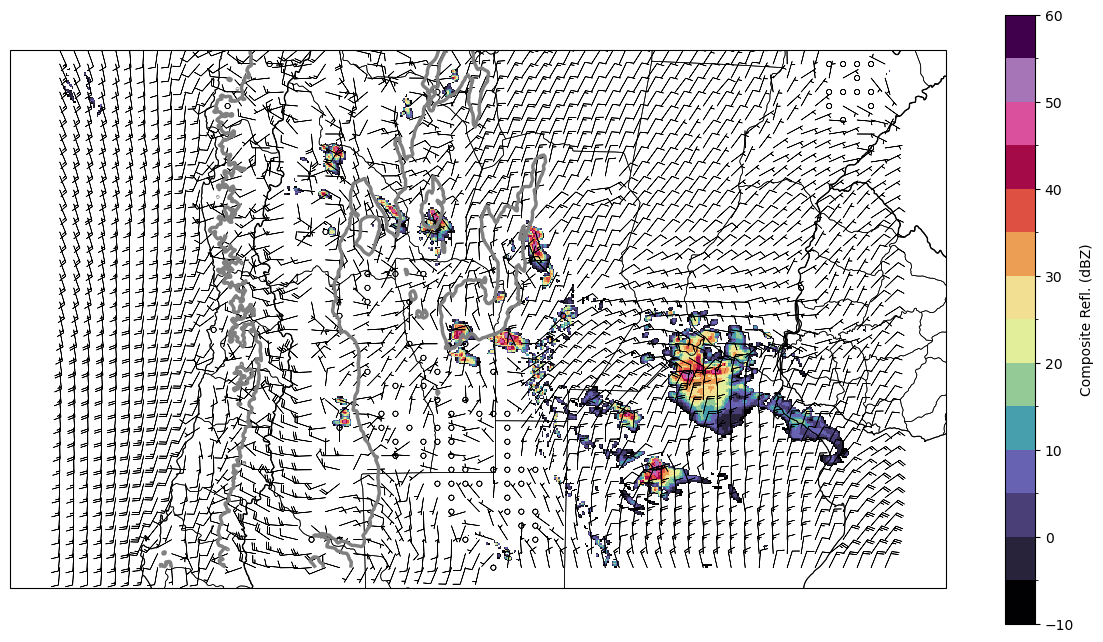

In [6]:
def get_fields(ncf, timeidx=0):
    """Return composite (column-max) reflectivity, 10-m winds, potential temp, and timestamp."""
    bref  = wrf.getvar(ncf, 'dbz', timeidx=timeidx).isel(bottom_top=0)
    u10  = wrf.getvar(ncf, 'U10', timeidx=timeidx)
    v10  = wrf.getvar(ncf, 'V10', timeidx=timeidx)
    th2  = wrf.getvar(ncf, 'TH2', timeidx=timeidx)
    ts   = str(wrf.getvar(ncf, 'times', timeidx=timeidx, meta=False))
    return bref, u10, v10, th2, ts

ter = wrf.getvar(ncfiles[0], 'ter', timeidx=0)
import copy
# Make values below -10 dBZ appear white
REFL_CMAP_MASKED = copy.copy(plt.get_cmap(REFL_CMAP) if isinstance(REFL_CMAP, str) else REFL_CMAP)
REFL_CMAP_MASKED.set_under("none")
refl_levels = np.arange(-10, 65, 5)  # -10 to 60 dBZ in 5 dBZ steps
norm_refl   = mcolors.BoundaryNorm(refl_levels, ncolors=REFL_CMAP_MASKED.N, clip=False)
s = SKIP_BARB

def plot_reflectivity(ncf, timeidx=0):
    bref, u10, v10, th2, timestamp = get_fields(ncf, timeidx)

    fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': cart_proj})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # Reflectivity fill
    rf = ax.pcolormesh(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(bref),
                        cmap=REFL_CMAP_MASKED, norm=norm_refl,
                        transform=ccrs.PlateCarree())
    plt.colorbar(rf, ax=ax, label='Composite Refl. (dBZ)', shrink=0.7)

    # 750 m terrain contour
    ax.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(ter),
                levels=[750], colors='gray', linewidths=2.5,
                transform=ccrs.PlateCarree())

    # Wind barbs (m/s → knots)
    ax.barbs(wrf.to_np(lons)[::s, ::s], wrf.to_np(lats)[::s, ::s],
              wrf.to_np(u10)[::s, ::s] * 1.94384,
              wrf.to_np(v10)[::s, ::s] * 1.94384,
              length=5, linewidth=0.5, color='black',
              transform=ccrs.PlateCarree())

    ax.add_feature(cfeature.BORDERS, linewidth=1.0, edgecolor='black')
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')

#     ax.set_title(f'Composite Reflectivity (dBZ) + 10-m Winds (kts)\n{timestamp}', fontsize=12)
    plt.tight_layout()
    return fig, ax

fig, ax = plot_reflectivity(ncfile, timeidx=0)
plt.savefig(os.path.join(RUN_DIR, 'refl_t0.png'), dpi=150, bbox_inches='tight')
plt.show()



## 3. Interactive Animation — All Forecast Hours

In [7]:
# Build index of all time steps across files
time_index = []
timestamps  = []
for fi, ncf in enumerate(ncfiles):
    ntimes = ncf.dimensions['Time'].size
    for ti in range(ntimes):
        t = wrf.getvar(ncf, 'times', timeidx=ti, meta=False)
        time_index.append((fi, ti))
        timestamps.append(str(t))
print(f'Total forecast steps: {len(time_index)}')
for ts in timestamps:
    print(' ', ts)

Total forecast steps: 13
  2019-01-25T12:00:00.000000000
  2019-01-25T13:00:00.000000000
  2019-01-25T14:00:00.000000000
  2019-01-25T15:00:00.000000000
  2019-01-25T16:00:00.000000000
  2019-01-25T17:00:00.000000000
  2019-01-25T18:00:00.000000000
  2019-01-25T19:00:00.000000000
  2019-01-25T20:00:00.000000000
  2019-01-25T21:00:00.000000000
  2019-01-25T22:00:00.000000000
  2019-01-25T23:00:00.000000000
  2019-01-26T00:00:00.000000000


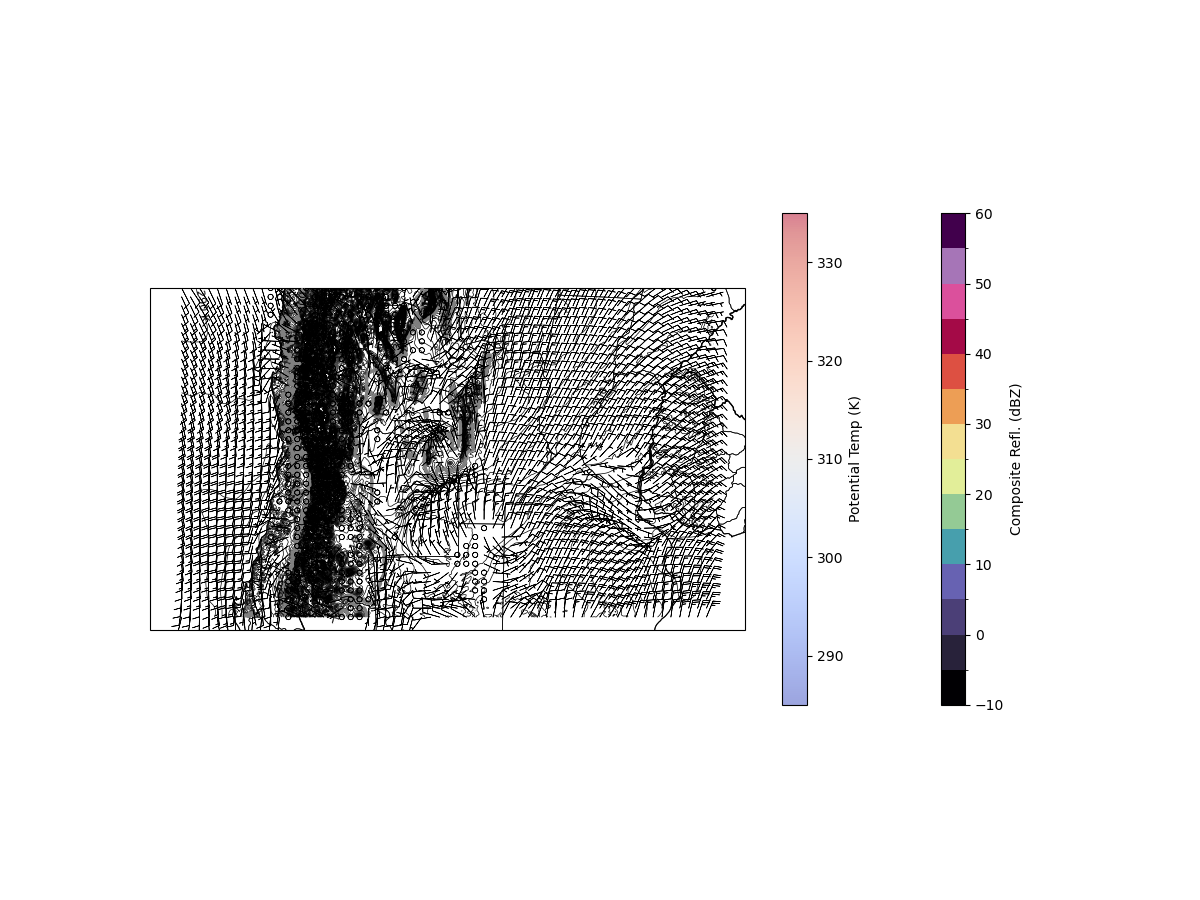

In [8]:
%matplotlib widget

fig, ax = plt.subplots(figsize=(12, 9), subplot_kw={'projection': cart_proj})
plt.subplots_adjust(bottom=0.1)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Static elements
ax.add_feature(cfeature.BORDERS, linewidth=1.0, edgecolor='black', zorder=5)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='black', zorder=5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black', zorder=5)

_topo_contour = [ax.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(ter),
            levels=[750], colors='gray', linewidths=2.5,
            transform=ccrs.PlateCarree(), zorder=4)]

# Initial plot components
fi0, ti0 = time_index[0]
cref0, u10_0, v10_0, th2_0, ts0 = get_fields(ncfiles[fi0], ti0)

refl_mesh = ax.pcolormesh(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(cref0),
                           cmap=REFL_CMAP_MASKED, norm=norm_refl,
                           transform=ccrs.PlateCarree(), zorder=2)
plt.colorbar(refl_mesh, ax=ax, label='Composite Refl. (dBZ)', shrink=0.7)

th2_mesh = ax.pcolormesh(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(th2_0),
                           cmap='coolwarm', vmin=285, vmax=335,
                           transform=ccrs.PlateCarree(), zorder=1, alpha=0.5)
th2_mesh.set_visible(False) # hidden by default
plt.colorbar(th2_mesh, ax=ax, label='Potential Temp (K)', shrink=0.7)

_barbs = [None]
_th2_contours = [None]
_th2_labels = [[]]

# title = ax.set_title(f'Weather Variables\n{ts0}', fontsize=12)

# Widgets
play = widgets.Play(value=0, min=0, max=len(time_index)-1, step=1, interval=700, description='▶')
slider = widgets.IntSlider(value=0, min=0, max=len(time_index)-1, step=1,
                            description='Step:', continuous_update=False,
                            style={'description_width': 'initial'},
                            layout=widgets.Layout(width='60%'))
ts_label = widgets.Label(value=timestamps[0])

stride_box = widgets.IntText(value=SKIP_BARB, description='Barb Stride:', layout=widgets.Layout(width='150px'))
check_refl = widgets.Checkbox(value=True, description='Reflectivity', indent=False, layout=widgets.Layout(width='120px'))
check_th2_mesh = widgets.Checkbox(value=False, description='TH2 Pcolormesh', indent=False, layout=widgets.Layout(width='150px'))
check_th2_contour = widgets.Checkbox(value=True, description='TH2 Contours', indent=False, layout=widgets.Layout(width='150px'))
check_barbs = widgets.Checkbox(value=True, description='Wind Barbs', indent=False, layout=widgets.Layout(width='120px'))
check_topo = widgets.Checkbox(value=True, description='Topography', indent=False, layout=widgets.Layout(width='120px'))

th2_vmin_box = widgets.FloatText(value=285.0, description='TH2 vmin:', layout=widgets.Layout(width='150px'))
th2_vmax_box = widgets.FloatText(value=335.0, description='TH2 vmax:', layout=widgets.Layout(width='150px'))

controls_hbox1 = widgets.HBox([play, slider, ts_label])
controls_hbox2 = widgets.HBox([check_refl, check_th2_mesh, check_th2_contour, check_barbs, check_topo])
controls_hbox3 = widgets.HBox([stride_box, th2_vmin_box, th2_vmax_box])

# Update function
def update_frame(change=None):
    step = slider.value
    fi, ti = time_index[step]
    cref, u10, v10, th2, timestamp = get_fields(ncfiles[fi], ti)
    
    # 1. Update Reflectivity
    refl_mesh.set_visible(check_refl.value)
    if check_refl.value:
        refl_mesh.set_array(wrf.to_np(cref).ravel())
        
    # 2. Update TH2 Pcolormesh
    th2_mesh.set_visible(check_th2_mesh.value)
    if check_th2_mesh.value:
        th2_mesh.set_array(wrf.to_np(th2).ravel())
        th2_mesh.set_clim(vmin=th2_vmin_box.value, vmax=th2_vmax_box.value)
        
    # 3. Update Barbs
    s = stride_box.value
    lat_b = wrf.to_np(lats)[::s, ::s]
    lon_b = wrf.to_np(lons)[::s, ::s]
    
    if _barbs[0] is not None:
        _barbs[0].remove()
        _barbs[0] = None

    if check_barbs.value and s > 0:
        _barbs[0] = ax.barbs(lon_b, lat_b,
                              wrf.to_np(u10)[::s, ::s] * 1.94384,
                              wrf.to_np(v10)[::s, ::s] * 1.94384,
                              length=5, linewidth=0.5, color='black',
                              transform=ccrs.PlateCarree(), zorder=6)
                              
    # 4. Update TH2 contours
    if _th2_contours[0] is not None:
        if hasattr(_th2_contours[0], 'collections'):
            for c in _th2_contours[0].collections:
                c.remove()
        else:
            _th2_contours[0].remove()
        _th2_contours[0] = None
        
    for txt in _th2_labels[0]:
        try:
            txt.remove()
        except:
            pass
    _th2_labels[0] = []

    if check_th2_contour.value:
        vmin = th2_vmin_box.value
        vmax = th2_vmax_box.value
        if vmax <= vmin:
            vmax = vmin + 1
        levels = np.arange(np.floor(vmin), np.ceil(vmax) + 1, 1)
        cs = ax.contour(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(th2),
                        levels=levels, colors='black', linewidths=0.5,
                        transform=ccrs.PlateCarree(), zorder=3)
        _th2_contours[0] = cs
        _th2_labels[0] = ax.clabel(cs, levels=levels[::5], inline=True, fontsize=8, fmt='%d K')

    # 5. Update Topography
    if len(_topo_contour) > 0 and _topo_contour[0] is not None:
        if hasattr(_topo_contour[0], 'collections'):
            for c in _topo_contour[0].collections:
                c.set_visible(check_topo.value)
        else:
            _topo_contour[0].set_visible(check_topo.value)

#     title.set_text(f'Weather Variables\n{timestamp}')
    ts_label.value = timestamp
    fig.canvas.draw_idle()

widgets.jslink((play, 'value'), (slider, 'value'))
slider.observe(lambda change: update_frame(), names='value')
check_refl.observe(lambda change: update_frame(), names='value')
check_th2_mesh.observe(lambda change: update_frame(), names='value')
check_th2_contour.observe(lambda change: update_frame(), names='value')
check_barbs.observe(lambda change: update_frame(), names='value')
check_topo.observe(lambda change: update_frame(), names='value')
stride_box.observe(lambda change: update_frame(), names='value')
th2_vmin_box.observe(lambda change: update_frame(), names='value')
th2_vmax_box.observe(lambda change: update_frame(), names='value')

# Trigger initial plot to draw everything according to widgets
update_frame()

display(widgets.VBox([controls_hbox1, controls_hbox2, controls_hbox3]))
plt.show()

